## Python programs
I created a class object that is called a [Region](#object-orientation). This object has differnent variables and functions associated with it. It was designed with the objective of being able to quickly and flexibly complete the following tasks:

 - Mean monthly CG [flash density](#flash-density) for a region; [~ 1km grid](#1km-grid)
 - Mean monthly [diurnal cycle](#diurnal-cycle) of CG flash density by month for a region
 - [Largest 100](#top-100) CG flash density days (12 UTC - 12 UTC) for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 
 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from __init__ import *
from plotting import *

%matplotlib inline

If you have already install dask (in terminal: `conda install dask`), the files are in good order, and all have the same variables, then this will work:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])

In [92]:
ds = xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/Cedar_City_UT/*_01_*.nc', 
                       concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']]))

In [93]:
ds.close()

## 1km grid

Once we have all the settings and imports, we should grid the data. This is a good [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about doing that. The premise is that we want to count the strikes within each bin, so we can use a 2D histogram.

In [ ]:
x = ds.lon.values
y = ds.lat.values

gridx = np.linspace(x.min(), x.max(), 600)
gridy = np.linspace(y.min(), y.max(), 600)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

In [ ]:
plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
den = ax.pcolor(gridx, gridy, density, cmap='Reds')
plt.colorbar(den, ax=ax)

## flash density
Look [here](#object-orientation) for more info or to make changes.

In [255]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=60)

In [256]:
MMDC_grid = {}
MMFC_grid = {}
for m in range(1,13):
    print m
    ds = c.get_ds(m=m, grid=True)
    c.to_diurnal(ds)
    ds.close()
    MMDC_grid.update({m: c.DC_grid})
    MMFC_grid.update({m: c.FC_grid})

1
2
3
4
5
6
7
8
9
10
11
12


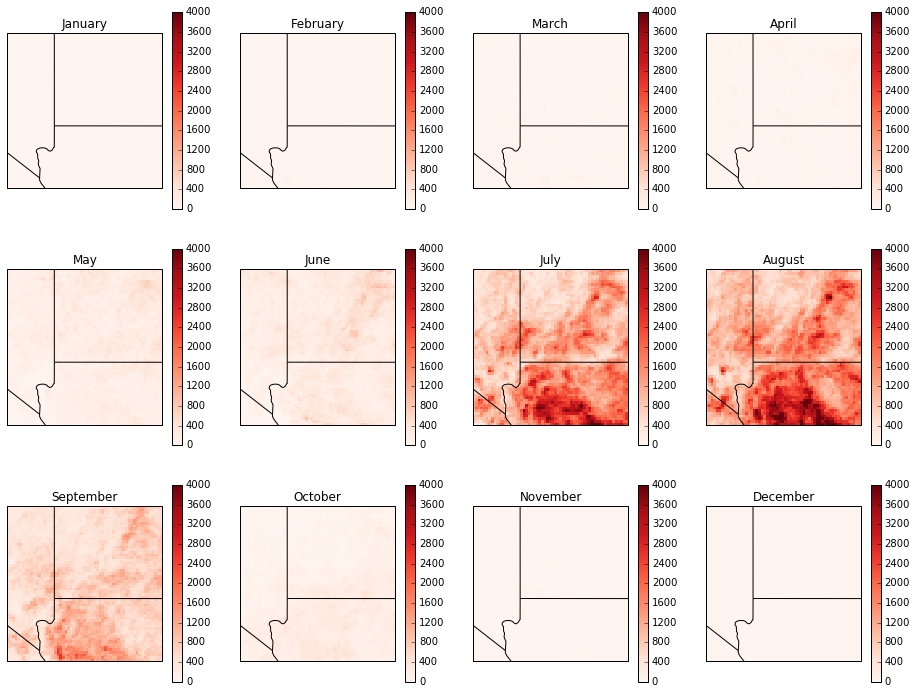

In [257]:
plt.figure(figsize=(16, 12))
for m in months.keys():
    ax = background(plt.subplot(3, 4, m, projection=ccrs.PlateCarree()))
    den = ax.pcolor(c.gridx, c.gridy, MMFC_grid[m], cmap='Reds', vmin=0, vmax=4000)
    ax.set_title(months[m])
    plt.colorbar(den, ax=ax)
plt.savefig('output/Cedar City mean monthly flash count.png')

## diurnal cycle
Look [here](#object-orientation) for more info or to make changes.


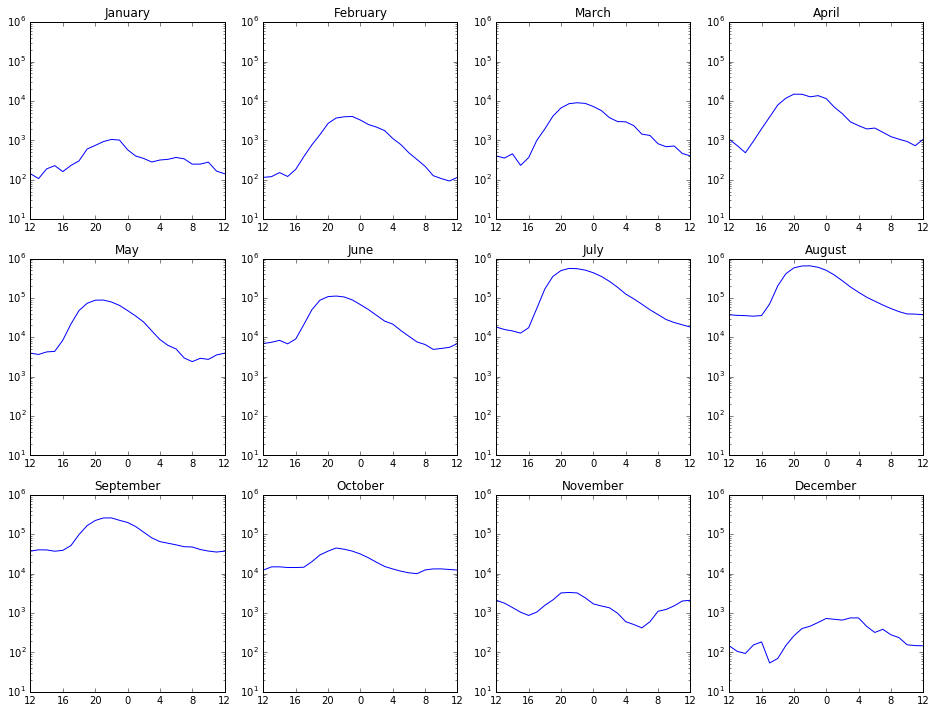

In [9]:
plt.figure(figsize=(16, 12))
for m in months.keys():
    ax = plt.subplot(3, 4, m)
    ax.plot([np.sum(MMDC_grid[m][hr]) for hr in h])
    ax.set_xticks(range(0,25,4))
    ax.set_xticklabels([h[n] for n in range(0,25,4)])
    ax.set_ylim(10**1, 10**6)
    ax.semilogy()
    ax.set_xlim(0,24)
    ax.set_title(months[m])
plt.savefig('output/Cedar City mean monthly diurnal cycle.png')

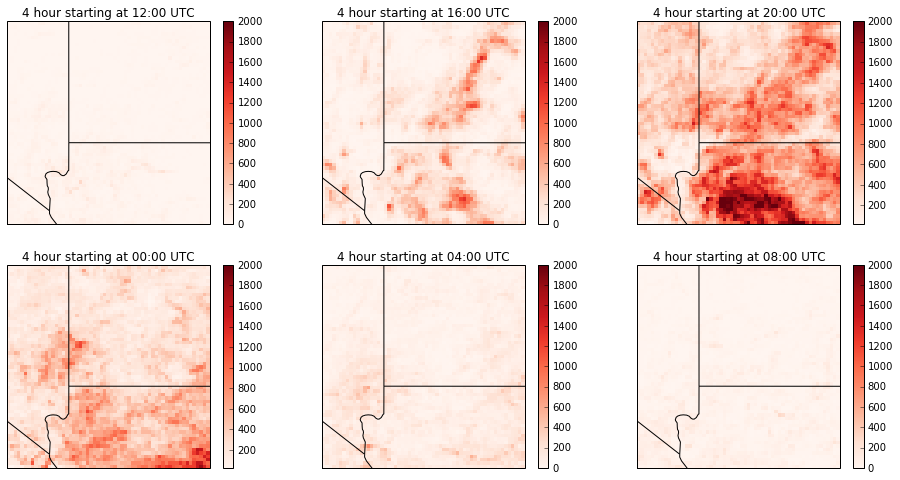

In [9]:
plt.figure(figsize=(16,8))
n=1
step = 4
for i in range(0,24,step):
    q=np.zeros(c.diurnal[0].shape)
    for hr in h[i:i+step]:
        q+=c.diurnal[hr]
    ax = plt.subplot(2, 3, n, projection=ccrs.PlateCarree())
    ax = background(ax)
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    den = ax.pcolor(c.gridx, c.gridy, q, cmap='Reds', vmax=2000)
    plt.colorbar(den, ax=ax)
    n+=1

## top 100
Once I figured out how the logic could be structured I included some new class functions in the Region class. Look [here](#object-orientation) for more info or to make changes.

In [246]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=60)

In [253]:
top10 = c.get_top_12to12(10)

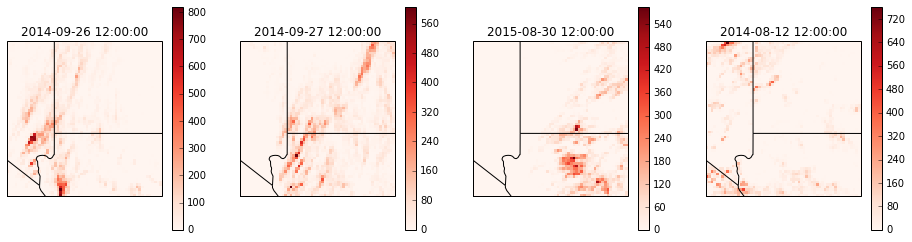

In [254]:
plt.figure(figsize=(16, 4))
for n in range(1,5):    
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ds0 = c.get_12to12_ds(top10.index[n-1],func='grid')
    ds0.close()
    den = ax.pcolor(c.gridx, c.gridy, c.FC_grid, cmap='Reds')
    ax.set_title(top10.index[n-1])
    plt.colorbar(den, ax=ax)

## object orientation
[Top](#Python-programs)

These are constant variables for each region so it makes to define a class to hold info and functions relating to the region. This is a first pass at such a class:

In [4]:
h = range(12,24)
h.extend(range(0,13))

In [5]:
months = {1: 'January', 2:'February', 3:'March', 4: 'April', 5:'May',6: 'June', 
          7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

In [245]:
class Region:
    '''
    Acronyms:
    FC = Flash Count
    DC = Diurnal Cycle
    MM = Mean Monthly
    '''
    def __init__(self, ds=None, **kwargs):
        if 'city' in kwargs:
            city = kwargs['city']
            self.CENTER = (city['lat'], city['lon'])
            self.RADIUS = city['r']
            self.PATH = city['path']
        else:
            self.CENTER = (lat, lon)
            self.RADIUS = (r)
        if type(ds) == xr.Dataset:
            self.get_x_y(ds)
    
    def define_grid(self, nbins, extents=[], **kwargs):
        if len(extents) > 0:
            minx, maxx, miny, maxy = extents
        else:
            minx = self.CENTER[1]-self.RADIUS
            maxx = self.CENTER[1]+self.RADIUS
            miny = self.CENTER[0]-self.RADIUS
            maxy = self.CENTER[0]+self.RADIUS
        self.gridx = np.linspace(minx, maxx, nbins)
        self.gridy = np.linspace(miny, maxy, nbins)
    
    def get_ds(self, path=None, cols=['strokes', 'amplitude'], func='grid', **kwargs):
        if type(path) != str:
            path = self.PATH
            
        yyyy, mm, dd = ('*', '*', '*')    
        if 'y' in kwargs:
            yyyy = str(kwargs['y'])
        if 'm' in kwargs:
            mm = '{m:02d}'.format(m=kwargs['m'])
        if 'd' in kwargs:
            dd = '{d:02d}'.format(d=kwargs['d'])
        fname = '{y}_{m}_{d}.nc'.format(y=yyyy, m=mm, d=dd)  
        
        ds = xr.open_mfdataset(path+fname, concat_dim='record', preprocess=(lambda x: x[cols]))
        self.get_x_y(ds)
        if func == 'grid':
            self.FC_grid = self.__to_grid()
        return(ds)
        
    def get_x_y(self, ds):
        self.x = ds.lon.values
        self.y = ds.lat.values
        
    def __to_grid(self, group=None, **kwargs):        
        if hasattr(group, '__iter__'):
            grid, _, _ = np.histogram2d(self.x[group], self.y[group], bins=[self.gridx, self.gridy], **kwargs)
        else:
            grid, _, _ = np.histogram2d(self.x, self.y, bins=[self.gridx, self.gridy], **kwargs)
        return(grid.T)
    
    def to_diurnal(self, ds):
        if not hasattr(self, 'x'):
            self.get_x_y(ds)
        gb = ds.groupby('time.hour')
        d = {}
        for k, v in gb.groups.items():
            d.update({k: self.__to_grid(v)})
        self.DC_grid = d
    
    def ncfile(self, t, check_existence=True):
        t = pd.Timestamp(t)
        fname = str(t.date()).replace('-','_')+'.nc'
        if check_existence:
            if os.path.isfile(self.PATH+fname):
                return fname
            else:
                return
        return fname
    
    def get_12to12_ds(self, t='2014-09-26', func='grid'):
        if pd.Timestamp(t).hour != 12:
            t = pd.Timestamp(str(t)[0:10]+' 12:00')
        else:
            t = pd.Timestamp(t)
            
        f0 = self.ncfile(t)
        f1 = self.ncfile(t+pd.DateOffset(1))
        
        ds = xr.concat([xr.open_dataset(self.PATH+f) for f in [f0, f1]], dim='record')
        UTC12 = [np.datetime64(t) for t in pd.date_range(start=t, periods=2)]
        
        ds0 = ds.where((ds.time>UTC12[0]) & (ds.time<UTC12[1])).dropna('record')
        ds.close()
        self.get_x_y(ds0)
        if func=='grid':
            self.FC_grid = self.__to_grid() 
        return(ds0)

    def get_top_12to12(self, n=100):
        d={}
        fnames = [str(t.date()).replace('-','_')+'.nc' for t in pd.date_range('1991-01-01', '2010-01-01')]
        d = self.__get_top(fnames, d, n=n*2)
        fnames = [str(t.date()).replace('-','_')+'.nc' for t in pd.date_range('2010-01-01', '2015-10-02')]
        d = self.__get_top(fnames, d, n=n*2)
        s = pd.Series(d).sort_values(ascending=False).head(n) 
        return s

    def __get_fsizes(self, fnames):
        fsizes = []
        for i in range(len(fnames)):
            try:
                fsizes.append(os.stat(self.PATH+fnames[i]).st_size)
            except:
                fsizes.append(0)
        s = pd.Series(fsizes, index=fnames)
        s = s.sort_values(ascending=False)
        return s

    def __get_top(self, fnames, d, n=200):
        s = self.__get_fsizes(fnames)
        for i in range(n):
            t = pd.Timestamp(s.index[i].strip('.nc').replace('_','-')+' 12:00')
            ifname = fnames.index(s.index[i])
            little_fnames = [self.PATH+f for f in fnames[ifname-1:ifname+2] if os.path.isfile(self.PATH+f)]

            ds = xr.concat([xr.open_dataset(f) for f in little_fnames], dim='record')
            UTC12 = [np.datetime64(t) for t in pd.date_range(start=t-pd.DateOffset(1), periods=3)]

            d.update({pd.Timestamp(UTC12[0]): ds.where((ds.time>UTC12[0]) & (ds.time<UTC12[1])).dropna('record').dims.values()[0]})
            d.update({pd.Timestamp(UTC12[1]): ds.where((ds.time>UTC12[1]) & (ds.time<UTC12[2])).dropna('record').dims.values()[0]})
            ds.close()
        return(d)   